In [26]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

Skipping, found downloaded files in "./rice-type-classification" (use force=True to force download)


In [27]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [28]:
device

'cpu'

In [29]:
df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


In [30]:
df.dropna(inplace=True)
df.drop(columns=['id'], inplace=True)

In [31]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [32]:
df['Class'].unique()

array([1, 0])

In [33]:
df.shape

(18185, 11)

In [34]:
original_df = df.copy()

In [35]:
for column in df.columns:
  df[column] = df[column]/df[column].abs().max()
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [36]:
X = np.array(df.iloc[:, :-1])
Y = np.array(df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)


In [37]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [38]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X = torch.tensor(X, dtype = torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

training_data = dataset(X_train,y_train)
validation_data = dataset(X_val, y_val)
testing_data = dataset(X_test, y_test)


In [39]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [40]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)

In [41]:
X.shape

(18185, 10)

In [42]:
class MyModel(nn.Module):
  def __init__(self):

    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [43]:
summary(model,  (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [44]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

In [45]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for data in train_dataloader:

    inputs, labels = data
    prediction = model(inputs).squeeze(1)

    batch_loss = criterion(prediction, labels)
    total_loss_train += batch_loss.item()

    acc = ((prediction).round() == labels).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in validation_dataloader:

      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == labels).sum().item()

      total_acc_val += acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

  print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
  print("="*150)


Epoch no. 1 Train Loss: 0.2447 Train Accuracy: 77.8616 Validation Loss: 0.0419 Validation Accuracy: 93.6584
Epoch no. 2 Train Loss: 0.1316 Train Accuracy: 97.2268 Validation Loss: 0.0186 Validation Accuracy: 98.0572
Epoch no. 3 Train Loss: 0.0619 Train Accuracy: 97.9181 Validation Loss: 0.0102 Validation Accuracy: 98.3871
Epoch no. 4 Train Loss: 0.0385 Train Accuracy: 98.3031 Validation Loss: 0.0073 Validation Accuracy: 98.5337
Epoch no. 5 Train Loss: 0.0291 Train Accuracy: 98.4602 Validation Loss: 0.0057 Validation Accuracy: 98.6070
Epoch no. 6 Train Loss: 0.0244 Train Accuracy: 98.4995 Validation Loss: 0.0052 Validation Accuracy: 98.5337
Epoch no. 7 Train Loss: 0.0218 Train Accuracy: 98.5466 Validation Loss: 0.0044 Validation Accuracy: 98.6437
Epoch no. 8 Train Loss: 0.0201 Train Accuracy: 98.6095 Validation Loss: 0.0041 Validation Accuracy: 98.5337
Epoch no. 9 Train Loss: 0.0190 Train Accuracy: 98.6252 Validation Loss: 0.0043 Validation Accuracy: 98.6070
Epoch no. 10 Train Loss: 0.0

In [46]:

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for data in testing_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)

    batch_loss_test = criterion((prediction), labels)
    total_loss_test += batch_loss_test.item()
    acc = ((prediction).round() == labels).sum().item()
    total_acc_test += acc

print(f"Accuracy Score is: {round((total_acc_test/X_test.shape[0])*100, 2)}%")

Accuracy Score is: 98.86%


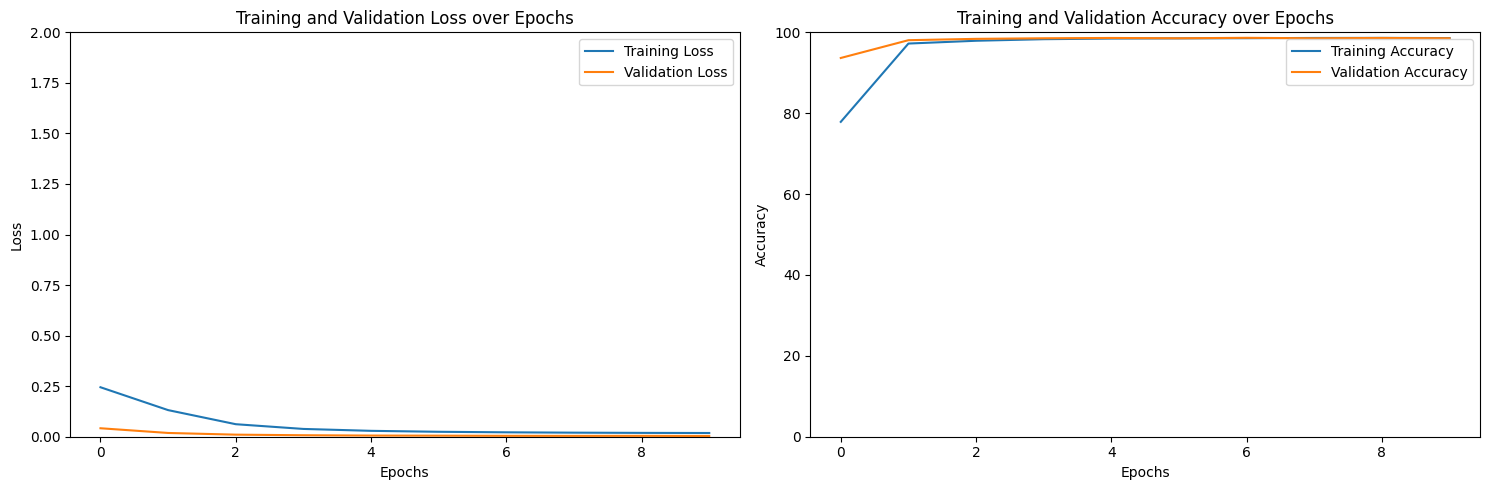

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()